<a href="https://colab.research.google.com/github/odhrandooley/Met-Eireann/blob/main/MainDocument.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install rasterio

from osgeo import gdal
import matplotlib.image as img
import os
import numpy as np
import tifffile as tif
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import rasterio
import cv2
from rasterio import plot
from rasterio.plot import show
from skimage import exposure
!pip install pyproj
from pyproj import Proj, transform
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, ColorConverter

!pip install netcdf4

!pip install rioxarray

import xarray as xr
import rioxarray as rio

from osgeo import gdal

!pip install git+git://github.com/geopandas/geopandas.git

import pandas as pd
import geopandas as gpd


     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 6.6 MB 9.0 MB/s 
     |████████████████████████████████| 46 kB 2.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for rioxarray: filename=rioxarray-0.7.0-py3-none-any.whl size=53826 sha256=60140ebfb2b1e55762e26275f8ddc087641c4c77790b2abb49cf5c372f65d030
  Stored in directory: /root/.cache/pip/wheels/64/25/e2/1d0324f336102268cae46738e21018b35b23a5adc3f9088a38
Successfully built rioxarray
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-fp3g93ko
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-fp3g93ko
     |████████████████████████████████| 15.4 MB 36 kB/s 
  Created wheel for geopandas: filename=geopandas-0.9.0+59.g4536b92-py2.py3-none-any.whl size=998383 sha256=ccd308b1ad59d47c799da0b13858999596aab79d17db55817ba1e86796e66f85

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
Labels = ['No Data','Water','Wetlands','Forest and Semi-Natural Areas','Artificial Surfaces','Agricultural Areas']

In [4]:
fnESACCI='/content/drive/MyDrive/ESA-CCI/C3S-LC-L4-LCCS-Map-300m-P1Y-2018-v2.1.1.nc'
file_legend='/content/drive/MyDrive/CORINE/u2018_clc2018_v2020_20u1_raster100m/Legend/CLC2018_CLC2018_V2018_20_QGIS.txt'
fncorine='/content/drive/MyDrive/CORINE/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif'
fnameSG='/content/drive/MyDrive/ECOCLIMAP_SG/ecosg_final_map.dir' #ecosg filename
covernamef='/content/drive/MyDrive/ECOCLIMAP_SG/ECOCLIMAP_SG_cover_data.csv'

In [5]:
c0=(0/255.0,0/255.0,0/255.0,255/255.0)## 0 no value
c1=(0/255.0,0/255.0,128/255.0,255/255.0)##navy blue 1. Water
c2 ="darkseagreen" # brown, wetlands
c3="khaki"#limegreen 3. nature
c4=(138/255.0,2/255.0,0/255.0,255/255.0)## red 4 art
c5="limegreen"#agri

scheme=[c0,c1,c2,c3,c4,c5]
col = ListedColormap(scheme)

##Initial cutting

In [6]:
#Coordinates for CORINE,ECOSG,ESACCI initial cutting around Ireland


LATMAX=56
LATMIN=50
LONMIN=-12
LONMAX=-4

latmax=56
latmin=50
lonmin=-12
lonmax=-4

projectionTO = 'EPSG:3035'
PROJECTION=Proj(projectionTO)

projx,projy=PROJECTION(longitude=[lonmin,lonmax,lonmax,lonmin],
                       latitude=[latmin,latmax,latmin,latmax])
xmin=min(projx)
xmax=max(projx)
ymin=min(projy)
ymax=max(projy)

In [7]:
xmin,ymax,xmax,ymin

(2770717.813022963, 3863994.4734923844, 3453337.5188303194, 3083054.5969610764)

In [8]:
print(PROJECTION(xmin,ymax, inverse=True))
print(PROJECTION(xmin,ymin, inverse=True))
print(PROJECTION(xmax,ymin, inverse=True))
print(PROJECTION(xmax,ymax, inverse=True))

(-15.053996151158646, 55.41542904783779)
(-11.446249901784878, 48.806831726266026)
(-2.2182381899556276, 50.2068006244872)
(-4.409466122189721, 57.08906468645186)


Cutting CORINE

In [9]:

res=100
src_fn=fncorine
out_fn='CORINEcut100m.tif' # 10m cutted filename
ds=gdal.Open(src_fn)
gdal.Translate(out_fn,ds,projWin = [xmin,ymax,xmax,ymin],projWinSRS=projectionTO,xRes=res,yRes=res) 

!gdalinfo $out_fn

Driver: GTiff/GeoTIFF
Files: CORINEcut100m.tif
Size is 6826, 7809
Coordinate System is:
PROJCS["ETRS89 / LAEA Europe",
    GEOGCS["ETRS89",
        DATUM["European_Terrestrial_Reference_System_1989",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6258"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4258"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",52],
    PARAMETER["longitude_of_center",10],
    PARAMETER["false_easting",4321000],
    PARAMETER["false_northing",3210000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","3035"]]
Origin = (2770700.000000000000000,3864000.000000000000000)
Pixel Size = (100.000000000000000,-100.000000000000000)
Metadata:
  AREA_OR_POINT=Area
 

Cut and reproject ECOSG

In [10]:


inECO = gdal.Open(fnameSG)
cutECO = 'ECO_cut.tif'

gdal.Translate(cutECO,inECO,
               projWin=[lonmin,latmax,lonmax,latmin], 
               projWinSRS='EPSG:4326')

dsECO=gdal.Open(cutECO)

projectionTO = 'EPSG:3035'
warpSG = 'ECO_3035.tif'
gdal.Warp(warpSG, dsECO, dstSRS=projectionTO,srcSRS='EPSG:4326',xRes=res,yRes=res)

outECO = 'ECOcut3035.tif'
dscutECO = gdal.Open(warpSG)
gdal.Translate(outECO,dscutECO,projWin = [xmin,ymax,xmax,ymin],projWinSRS=projectionTO)



#pixel size and number is the same, just slightly different bounds

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fd828739450> >

ESACCI

In [13]:


#xds = xr.open_dataset(fnESACCI)
#xds.rio.write_crs("epsg:4326", inplace=True)
ncfile = xr.open_dataset(fnESACCI)
#Crop the file

LAT=ncfile['lat'][(ncfile['lat']<LATMAX)&(ncfile['lat']>LATMIN)]
LON=ncfile['lon'][(ncfile['lon']<LONMAX)&(ncfile['lon']>LONMIN)]
var=ncfile['lccs_class'][0,(ncfile['lat']<LATMAX)&(ncfile['lat']>LATMIN),
                         (ncfile['lon']<LONMAX)&(ncfile['lon']>LONMIN)]

#Check for the CRS
print(ncfile['crs'])
# add the crs value
var.rio.write_crs("epsg:4326", inplace=True)
#var=var.rio.set_crs("epsg:4326")

inESA  = 'raster.tif'
var.rio.to_raster(inESA)

<xarray.DataArray 'crs' ()>
array(-2147483647, dtype=int32)
Attributes:
    wkt:      GEOGCS["WGS 84", \n  DATUM["World Geodetic System 1984", \n    ...
    i2m:      0.002777777777778,0.0,0.0,-0.002777777777778,-180.0,90.0


In [14]:
#Cut and project ESACCI

inESA  = 'raster.tif'

cutESA = 'ESA_cut.tif'

gdal.Translate(cutESA,inESA,
               projWin=[lonmin,latmax,lonmax,latmin], 
               projWinSRS='EPSG:4326')

dsESA=gdal.Open(cutESA)
print(dsESA)
projectionTO = 'EPSG:3035'
warpESA = 'ESA_3035.tif'
gdal.Warp(warpESA, dsESA, dstSRS=projectionTO,srcSRS='EPSG:4326',xRes=res,yRes=res)

outESA = 'ESAcut3035.tif'
dscutESA = gdal.Open(warpESA)            
gdal.Translate(outESA,dscutESA,projWin = [xmin,ymax,xmax,ymin],
               projWinSRS=projectionTO)

#!gdalinfo $outESA

#pixel size and number is the same, just slightly different bounds

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fd830713d20> >


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fd8282f9a80> >

#Open Data

##misc functions

In [15]:
def cover_fraction(filename):
    data=open(filename)
    covernum=[]
    covername=[]
    cityfrac=[]
    vegfrac=[]
    inwaterfrac=[]
    seafrac=[]
    for i,d in enumerate(data):
        if i==0:
            fieldnames=d.split(',')
            covername.append('no data')
            cityfrac.append(0.0)
            vegfrac.append(0.0)
            inwaterfrac.append(0.0)
            seafrac.append(0.0)
        else:
#           print(d.split(','))
            covernum.append(int(d.split(',')[0]))
            covername.append(d.split(',')[1])
            cityfrac.append(float(d.split(',')[2]))
            vegfrac.append(float(d.split(',')[3]))
            inwaterfrac.append(float(d.split(',')[4]))
            seafrac.append(float(d.split(',')[5]))
    return(fieldnames,np.array(covernum),covername,np.array(cityfrac),np.array(vegfrac),
           np.array(inwaterfrac),np.array(seafrac))

In [16]:
def read_legend_file(file_legend):

  data=open(file_legend)
  text=[t for t in data]
  covernum=[int(d.split(',')[0]) for d in text]
  colors=[tuple((int(d.split(',')[1])/255.0,int(d.split(',')[2])/255.0,int(d.split(',')[3])/255.0,int(d.split(',')[4])/255.0)) for d in text]
  covername=[d.split(',')[5] for d in text]
  return(data,text,covernum,colors,covername)

##Get lat,lon,array

In [17]:
def get_data(fname,latmax,latmin,lonmax,lonmin):

    gdal.UseExceptions()
    ds = gdal.Open(fname)
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    #
    #
    #
    xres = gt[1]
    yres = gt[5]
    #
    xmin = gt[0]
    ymin = gt[3]
    #
    xmax = gt[0] + (xres * ds.RasterXSize)
    ymax = gt[3] + (yres * ds.RasterYSize)
#    else:
#        xmax = gt[0] + (xres * ds.RasterXSize) 
#        ymax = gt[3] + (yres * ds.RasterYSize) 


    X=np.arange(xmin+xres,xmax+xres,xres)
    Y=np.arange(ymin+yres,ymax+yres,yres)


    #Chunck the data to save RAM for plotting
    #Ydecreasing
    b=np.min(np.where(Y<latmin)[0])
    a=np.max(np.where(Y>latmax)[0])

    c=np.max(np.where(X<lonmin)[0])
    d=np.min(np.where(X>lonmax)[0])

#    print(np.max(data))
#    print(np.min(data))
    #ECOCLIMAP data have no projections so no need to reproject the data
    #to be verified for other datasets
    LAT=Y[a:b]
    LON=X[c:d]
    D=data[a:b,c:d]

    return (LAT,LON,D)

#Choose Sentinel Tile Here

In [18]:

dirfiles='/content/drive/MyDrive/UW_map/T29/Galway'
primaryorsecondary=1 #1 Primary 2 secondary


#Sentinel/UW

##Functions

In [19]:

def directorystructure(dirfiles,primaryorsecondary):
  if 'T29' in dirfiles:
    projection='EPSG:32629' # UTM 29 code
  if 'T30' in dirfiles:
    projection='EPSG:32630' # UTM 30 code

  if primaryorsecondary==1:
    pathending='Primary Prediction.tif'
  if primaryorsecondary==2:
    pathending='Secondary Prediction.tif'

  predictionfn=os.path.join(dirfiles,pathending)
  
  return(projection,predictionfn)

In [20]:

def sentinel2safepath(path):
  """
  obtain the safe path to the sentinel-2 .SAFE dir containing image and it's metadata
  path=the city path i.e /content/drive/MyDrive/UW_map/T29/Galway
  return the sentinel-2 .SAFE dir containing image and it's metadata
  """
  safepath=[os.path.join(path,f) for f in os.listdir(path) if f.endswith('SAFE')]
  if len(safepath[0])>1:
    safepath=safepath[0]
  return(safepath)

def metadata_folder(path):
    
    """obtain the path to the metadata file for sentinel-2 tiles 
        
        path = path of the sentinel-2 '.Safe' product file
        
        Returns: the path to the directory containing the metadata file
        
    """
    
    new_path=os.path.join(path,'GRANULE',os.listdir(os.path.join(path,'GRANULE'))[0],'MTD_TL.xml')
    
    return new_path 

def location_datac(path):
    
    """ parse the xml metadata file and retrieve the utm coordinates of the tile
    
        path: path to the xml metadata file
    
        Returns: utm coordinate of the top left and bottom right corners of the tile
    """
    
    tree = (ET.parse(path)).getroot() #parse the file
    
    x_length = 10*int(tree[1][0][2][0].text) #obtain the x_dim length
    
    y_length = 10*int(tree[1][0][2][1].text) #obtain the y_dim length
    
    upper_left_x = int(tree[1][0][5][0].text) #obtain upper left x coordinate
    
    upper_left_y = int(tree[1][0][5][1].text) #obtain upper left y coordinate
    
    lower_right_x = upper_left_x + x_length #obtain lower right x coordinate
    
    lower_right_y = upper_left_y - y_length #obtain lower right y coordinate
    
    return upper_left_x,upper_left_y,lower_right_x,lower_right_y

In [21]:
def ten_path(path):
    
    """obtain the path to the 10 metre resolution sentinel-2 tiles from the 
        overall directory
        
        path = path of the sentinel-2 '.Safe' product file
        
        Returns: the path to the directory containing the 10 metre resolution .jp2 files
        
        """
    
    new_path=os.path.join(path,'GRANULE',os.listdir(os.path.join(path,'GRANULE'))[0],'IMG_DATA','R10m')
    
    return new_path

def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))
    
def load_jp2(path):
    
    """from the path obtained using ten_path() load the .jp2 files and then
       create a 3 channel numpy array, corresponding to a rgb image
        
        path = path of 10m resolution product
        
        Returns: 3 channel array corresponding to rgb tile image
        
        """
    files = sorted(os.listdir(path))
    
    blue = rasterio.open(os.path.join(path,files[1]), driver='JP2OpenJPEG').read(1) #blue band .jp2 file
    green = rasterio.open(os.path.join(path,files[2]), driver='JP2OpenJPEG').read(1)#green band .jp2 file
    red = rasterio.open(os.path.join(path,files[3]), driver='JP2OpenJPEG').read(1) #red band .jp2 file

    image = np.dstack((red,green,blue)) #stack the files and create rgb image

    p2, p98 = np.percentile(image, (2,98)) # rescaling image
    image=exposure.rescale_intensity(image, in_range=(p2, p98))/10000
    if image.max()>1:
      image=image/image.max()
    return image

def save_tif(array,filename,load_tif=True):
  
    """save the .jp2 arrays as tifs 
        
        array = array obtained using load_jp2()
        
        filename = 'filename.tif'
        
        load_tif = True ---reload the tif just saved and return it
        load_tif = False --- Don't load or return the tif
        
        Returns: 3 channel array corresponding to rgb tile image
        
        """
    
    tif.imsave(filename,array) #save the array as a tif file
    
    #reload the tif previously saved and return as numpy array
    if load_tif==True:
            
        image_tif = tif.imread(filename)
            
    return image_tif


In [22]:
def get_dataSEN(fname,latmax,latmin,lonmax,lonmin):

    gdal.UseExceptions()
    ds = gdal.Open(fname)
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    #
    #
    #
    xres = gt[1]
    yres = gt[5]
    #
    xmin = gt[0]
    ymin = gt[3]
    #
    xmax = gt[0] + (xres * ds.RasterXSize)
    ymax = gt[3] + (yres * ds.RasterYSize)
#    else:
#        xmax = gt[0] + (xres * ds.RasterXSize) 
#        ymax = gt[3] + (yres * ds.RasterYSize) 


    X=np.arange(xmin+xres,xmax+xres,xres)
    Y=np.arange(ymin+yres,ymax+yres,yres)


    #Chunck the data to save RAM for plotting
    #Ydecreasing
    b=np.min(np.where(Y<latmin)[0])
    a=np.max(np.where(Y>latmax)[0])

    c=np.max(np.where(X<lonmin)[0])
    d=np.min(np.where(X>lonmax)[0])

#    print(np.max(data))
#    print(np.min(data))
    #ECOCLIMAP data have no projections so no need to reproject the data
    #to be verified for other datasets
    LAT=Y[a:b]
    LON=X[c:d]
    D=data[:,a:b,c:d]

    return (LAT,LON,D)


##Functions/load tile

In [23]:
projection,predictionfn=directorystructure(dirfiles,primaryorsecondary)

In [24]:
ds=gdal.Open(predictionfn)
opt=gdal.TranslateOptions(xRes=10, yRes=10) 
gdal.Translate('Prediction10m.tif',ds,options=opt)
ds=None

In [25]:
s2path=sentinel2safepath(dirfiles)

In [26]:
metadatapath=metadata_folder(s2path)

In [27]:
(ulx,uly,lrx,lry)=location_datac(metadatapath)

In [28]:
ten_pathi = ten_path(s2path)

In [29]:
image=load_jp2(ten_pathi)

In [30]:
image=(image[30:10950,30:10950,:]*255).astype(int) 
#the UW map is cropped because there is an overlay between the sentinel-2 files

In [31]:
refds=gdal.Open('Prediction10m.tif')
refdriver=refds.GetDriver()

In [32]:
output_raster=refdriver.Create('rgb.tif',image.shape[0],
                               image.shape[1],
                               image.shape[2],
                               gdal.GDT_Int16)
gt=refds.GetGeoTransform()
out_proj=refds.GetProjection()
output_raster.SetProjection(out_proj)
output_raster.SetGeoTransform(gt)
output_raster.GetRasterBand(1).WriteArray(image[:,:,0])   # write r-band to the raster
output_raster.GetRasterBand(2).WriteArray(image[:,:,1])   # write g-band to the raster
output_raster.GetRasterBand(3).WriteArray(image[:,:,2])   # write b-band to the raster
output_raster.FlushCache() 
output_raster=None

In [33]:

#plotcol and numcol correspond to column number of each 
def toPrimaryDF(array, df,plotcol,numcol,covername):
  array1 = np.zeros([len(array),len(array[0])])
  for i in range(0, len(array)):
    for j in range(0,len(array[0])):
      for k in range(0,len(covername)):
        if array[i,j]== df.iloc[k,plotcol]:
          array1[i,j]=df.iloc[k,numcol] #assigns 1,2 or 3 to a new array based on primary covertype
  return array1


#Primary

In [34]:
#initial
labellist=['Clouds', #no data
           'Artificial surfaces and constructions', #Artificial
           'Cultivated areas', # agri
           'Vineyards', #agri
           'Broadleaf tree cover', #natural
           'Coniferous tree cover', #nat
           'Herbaceous vegetation', #nat
           'Moors and Heathland', #nat
           'Sclerophyllous vegetation', #nat
           'Marshes', #wetlands
           'Peatbogs', #wetlands
           'Natural material surfaces', #nat
           'Permanent snow covered surfaces', #nat
           'Water bodies']#wat

In [35]:

primary = []

primary.append('No Data')
primary.append('Artificial')
for i in range(0,2):
  primary.append('Agriculture')
for i in range(0,5):
  primary.append('Nature')
for i in range(0,2):
  primary.append('Wetlands')
for i in range(0,2):
  primary.append('Nature')
primary.append('Water')

  
primarynum = []
primarynum.append('0')
primarynum.append('4')
for i in range(0,2):
  primarynum.append('5')
for i in range(0,5):
  primarynum.append('3')
for i in range(0,2):
  primarynum.append('2')
for i in range(0,2):
  primarynum.append('3')
primarynum.append('1')

In [36]:
U=[0,62,73,75,82,83,102,103,104,105,106,121,123,162]

In [37]:
columns = ['Covername','Covernumber','Primary','Secondary']
index = np.arange(0,14,1)
df_S2G = pd.DataFrame(columns = columns)

df_S2G['Covername'] = labellist
df_S2G['Plotnum'] = index
df_S2G['Covernumber'] = U
df_S2G['Primary'] = primary
df_S2G['PrimaryNum'] = primarynum

In [38]:
df_S2G

,Covername,Covernumber,Primary,Secondary,Plotnum,PrimaryNum
0,Clouds,0,No Data,NaN,0,0
1,Artificial surfaces and constructions,62,Artificial,NaN,1,4
2,Cultivated areas,73,Agriculture,NaN,2,5
3,Vineyards,75,Agriculture,NaN,3,5
4,Broadleaf tree cover,82,Nature,NaN,4,3
5,Coniferous tree cover,83,Nature,NaN,5,3
6,Herbaceous vegetation,102,Nature,NaN,6,3
7,Moors and Heathland,103,Nature,NaN,7,3
8,Sclerophyllous vegetation,104,Nature,NaN,8,3
9,Marshes,105,Wetlands,NaN,9,2



CORINE

In [39]:
(data,text,covernum,colors,covername_COR) = read_legend_file(file_legend)

In [40]:

primary = []
for i in range(0,11):
  primary.append('Artificial')
for i in range(0,11):
  primary.append('Agriculture')
for i in range(0,12):
  primary.append('Nature')
for i in range(0,5):
  primary.append('Wetlands')
for i in range(0,5):
  primary.append('Water')
primary.append('No Data')

primarynum = []
for i in range(0,11):
  primarynum.append('4')
for i in range(0,11):
  primarynum.append('5')
for i in range(0,12):
  primarynum.append('3')
for i in range(0,5):
  primarynum.append('2')
for i in range(0,5):
  primarynum.append('1')
primarynum.append('0')

In [41]:
columns = ['Covername','Covernumber','Primary','Secondary']
index = np.arange(1,46,1)
df_COR = pd.DataFrame( columns = columns)

(data,text,covernum,colors,covername_COR) = read_legend_file(file_legend)

df_COR['Covername'] = covername_COR
df_COR['Plotnum'] = index
df_COR['Covernumber'] = covernum
df_COR['Primary'] = primary
df_COR['PrimaryNum'] = primarynum

In [42]:
df_COR

,Covername,Covernumber,Primary,Secondary,Plotnum,PrimaryNum
0,Continuous urban fabric\n,111,Artificial,NaN,1,4
1,Discontinuous urban fabric\n,112,Artificial,NaN,2,4
2,Industrial or commercial units\n,121,Artificial,NaN,3,4
3,Road and rail networks and associated land\n,122,Artificial,NaN,4,4
4,Port areas\n,123,Artificial,NaN,5,4
5,Airports\n,124,Artificial,NaN,6,4
6,Mineral extraction sites\n,131,Artificial,NaN,7,4
7,Dump sites\n,132,Artificial,NaN,8,4
8,Construction sites\n,133,Artificial,NaN,9,4
9,Green urban areas\n,141,Artificial,NaN,10,4


ESACCI

In [43]:
covername_ESA = var.flag_meanings.split()
covernum = var.flag_values
#covername_ESA

In [44]:

primarynum = []
primarynum.append('0')
for i in range(0,5):
  primarynum.append('5')
for i in range(0,23):
  primarynum.append('3')
for i in range(0,3):
  primarynum.append('2')
primarynum.append('4')
for i in range(0,3):
  primarynum.append('3')
primarynum.append('1')
primarynum.append('3')

primary = []
primary.append('No Data')
for i in range(0,5):
  primary.append('Agriculture')
for i in range(0,23):
  primary.append('Nature')
for i in range(0,3):
  primary.append('Wetlands')
primary.append('Artificial')
for i in range(0,3):
  primary.append('Nature')
primary.append('Water')
primary.append('Nature')

In [45]:
columns = ['Covername','Covernumber','Primary','Secondary']
#index = np.arange(0,len(covername_ESA),1)

df_ESA = pd.DataFrame(columns = columns)
df_ESA['Covername'] = covername_ESA
#df_ESA['Plotnum'] = index
df_ESA['Covernumber'] = covernum
df_ESA['Primary'] = primary
df_ESA['PrimaryNum'] = primarynum


In [46]:
df_ESA.iloc[23,2]='Agriculture'
df_ESA.iloc[23,4]=5
df_ESA

,Covername,Covernumber,Primary,Secondary,PrimaryNum
0,no_data,0,No Data,NaN,0
1,cropland_rainfed,10,Agriculture,NaN,5
2,cropland_rainfed_herbaceous_cover,11,Agriculture,NaN,5
3,cropland_rainfed_tree_or_shrub_cover,12,Agriculture,NaN,5
4,cropland_irrigated,20,Agriculture,NaN,5
5,mosaic_cropland,30,Agriculture,NaN,5
6,mosaic_natural_vegetation,40,Nature,NaN,3
7,tree_broadleaved_evergreen_closed_to_open,50,Nature,NaN,3
8,tree_broadleaved_deciduous_closed_to_open,60,Nature,NaN,3
9,tree_broadleaved_deciduous_closed,61,Nature,NaN,3


ECOSG

In [47]:
(fieldnames,covernum,covername_ECO,cityfrac,vegfrac,inwaterfrac,seafrac)=cover_fraction(covernamef)
#covername_ECO

In [48]:

primarynum = []
primarynum.append('0')
for i in range(0,3):
  primarynum.append('1')
for i in range(0,12):
  primarynum.append('3')
for i in range(0,6):
  primarynum.append('5')
for i in range(0,2):
  primarynum.append('2')
for i in range(0,10):
  primarynum.append('4')

primary = []
primary.append('No Data')
for i in range(0,3):
  primary.append('Water')
for i in range(0,12):
  primary.append('Nature')
for i in range(0,6):
  primary.append('Agriculture')
for i in range(0,2):
  primary.append('Wetlands')
for i in range(0,10):
  primary.append('Artificial')

In [49]:
Covernum=np.zeros(len(covername_ECO))
Covernum[1:34]=covernum

In [50]:


columns = ['Covername','Covernumber','Primary','Secondary']
index = np.arange(0,len(covername_ECO),1)

df_ECO = pd.DataFrame( columns = columns)
df_ECO['Covername'] = covername_ECO
df_ECO['Plotnum'] = index
df_ECO['Covernumber'] = Covernum
df_ECO['Primary'] = primary
df_ECO['PrimaryNum'] = primarynum

In [51]:
df_ECO

,Covername,Covernumber,Primary,Secondary,Plotnum,PrimaryNum
0,no data,0.0,No Data,NaN,0,0
1,Sea and ocean,1.0,Water,NaN,1,1
2,Inland waters,2.0,Water,NaN,2,1
3,Rivers,3.0,Water,NaN,3,1
4,Bare land,4.0,Nature,NaN,4,3
5,Rocks,5.0,Nature,NaN,5,3
6,Permanent snow and ice,6.0,Nature,NaN,6,3
7,boreal broadleaf deciduous,7.0,Nature,NaN,7,3
8,temperate broadleaf deciduous,8.0,Nature,NaN,8,3
9,tropical broadleaf deciduous,9.0,Nature,NaN,9,3


#Input Coords Here

In [52]:
centre_lat = 53.30
centre_lon = -9.34
extent =2500

projectionTO = 'EPSG:3035'

PROJECTION=Proj(projectionTO)

cx,cy = PROJECTION(centre_lon,centre_lat)

ymin = cy - extent
ymax = cy + extent
xmin = cx - extent
xmax = cx + extent

xmin,ymax,xmax,ymin, cy,cx

(3046660.4931802163,
 3528257.5835612444,
 3051660.4931802163,
 3523257.5835612444,
 3525757.5835612444,
 3049160.4931802163)

#Open S2GLC

In [53]:
ds=gdal.Open('/content/drive/MyDrive/S2GLCmap/S2GLC_Europe_2017_v1.2.tif')
Topt=gdal.TranslateOptions(projWin= [xmin, ymax, xmax, ymin],projWinSRS='EPSG:3035')
gdal.Translate('S2GLC.tif',ds,options=Topt)
ds=None

In [54]:
dsS2G=gdal.Open('S2GLC.tif')

In [55]:
Ar=dsS2G.ReadAsArray()

#scheme1=[c0,c3,c2,c2,c2,c2,c2,c2,c2,c2,c2,c2,c2,c1]

#newcmapS2G = ListedColormap(scheme1)
Arp=np.zeros(Ar.shape)
for i,u in enumerate(U):
    Arp[Ar==u]=i
#newcmap=ListedColormap(plotcmap)

#Plot

In [56]:
fname='CORINEcut100m.tif'
LATC,LONC, DCOR = get_data(fname,ymax,ymin,xmax,xmin)

fname = outECO
LATECO,LONECO, DECO = get_data(fname,ymax,ymin,xmax,xmin)


fname = outESA
LATESA,LONESA, DESA = get_data(fname,ymax,ymin,xmax,xmin)


In [57]:
print(np.shape(DECO))
print(np.shape(DESA))
print(np.shape(DCOR))

(51, 51)
(51, 51)
(51, 51)


In [58]:
PriECO = toPrimaryDF(DECO,df_ECO,4,5,covername_ECO)
PriESA = toPrimaryDF(DESA,df_ESA,1,4,covername_ESA)
PriCOR = toPrimaryDF(DCOR,df_COR,4,5,covername_COR)
PriS2G = toPrimaryDF(Arp,df_S2G,4,5,labellist)

53.3 -9.34 2500


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


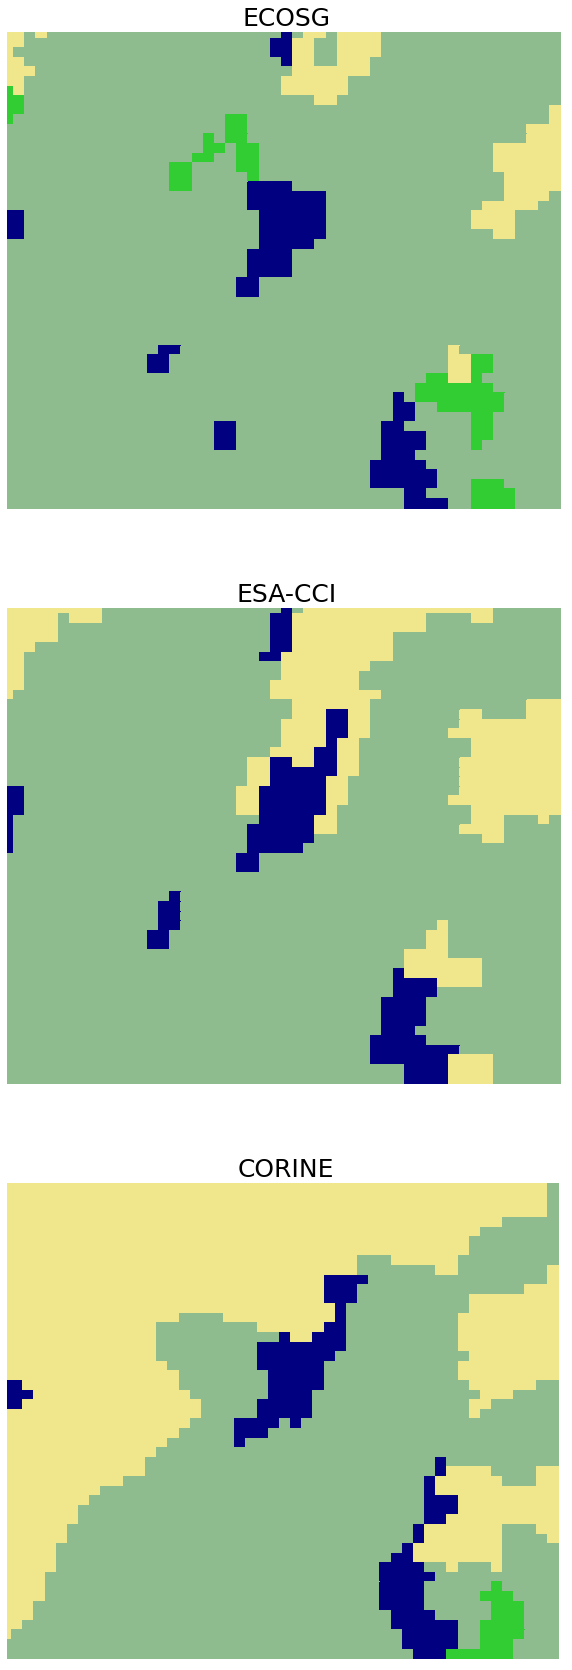

In [59]:
fig = plt.figure(figsize=(10,30))
gs = fig.add_gridspec(3, 1)
ax0 = fig.add_subplot(gs[0,0])
#ax0.set_title('gs[0, :]')
ax1 = fig.add_subplot(gs[1,0])
#f3_ax2.set_title('gs[1, :-1]')
ax2 = fig.add_subplot(gs[2,0])
#f3_ax3.set_title('gs[1:, -1]')


#fig, axs = plt.subplots(1, 1,figsize=(30, 30))
#ax1=axs

LONg, LATg = np.meshgrid(LONECO, LATECO)
c=ax0.pcolormesh(LONECO,LATECO,PriECO,cmap=col,vmin=0,vmax=len(Labels))

ax0.set_xlim(xmin,xmax)
ax0.set_ylim(ymin,ymax)

LONg, LATg = np.meshgrid(LONESA, LATESA)
c=ax1.pcolormesh(LONESA,LATESA,PriESA,cmap=col,vmin=0,vmax=len(Labels))

ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)

LONg, LATg = np.meshgrid(LONC, LATC)
c=ax2.pcolormesh(LONC,LATC,PriCOR,cmap=col,vmin=0,vmax=len(Labels))

ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)




ax0.axis('off')
ax1.axis('off')
ax2.axis('off')

ax2.set_title('CORINE', fontsize= 25)
ax0.set_title('ECOSG', fontsize= 25)
ax1.set_title('ESA-CCI', fontsize= 25)

print(centre_lat,centre_lon,extent)
#cb=plt.colorbar(c, ax=ax, ticks=np.arange(0.5,len(Labels)),extendfrac='auto', spacing='proportional')   
#cb.set_ticklabels(Labels)
#cb.ax.tick_params(labelsize=15)
fig.savefig('Limerick3PlotNew.png',format='png',quality=95,bbox_inches='tight')

#Plot ESA

#Plot S2GLC

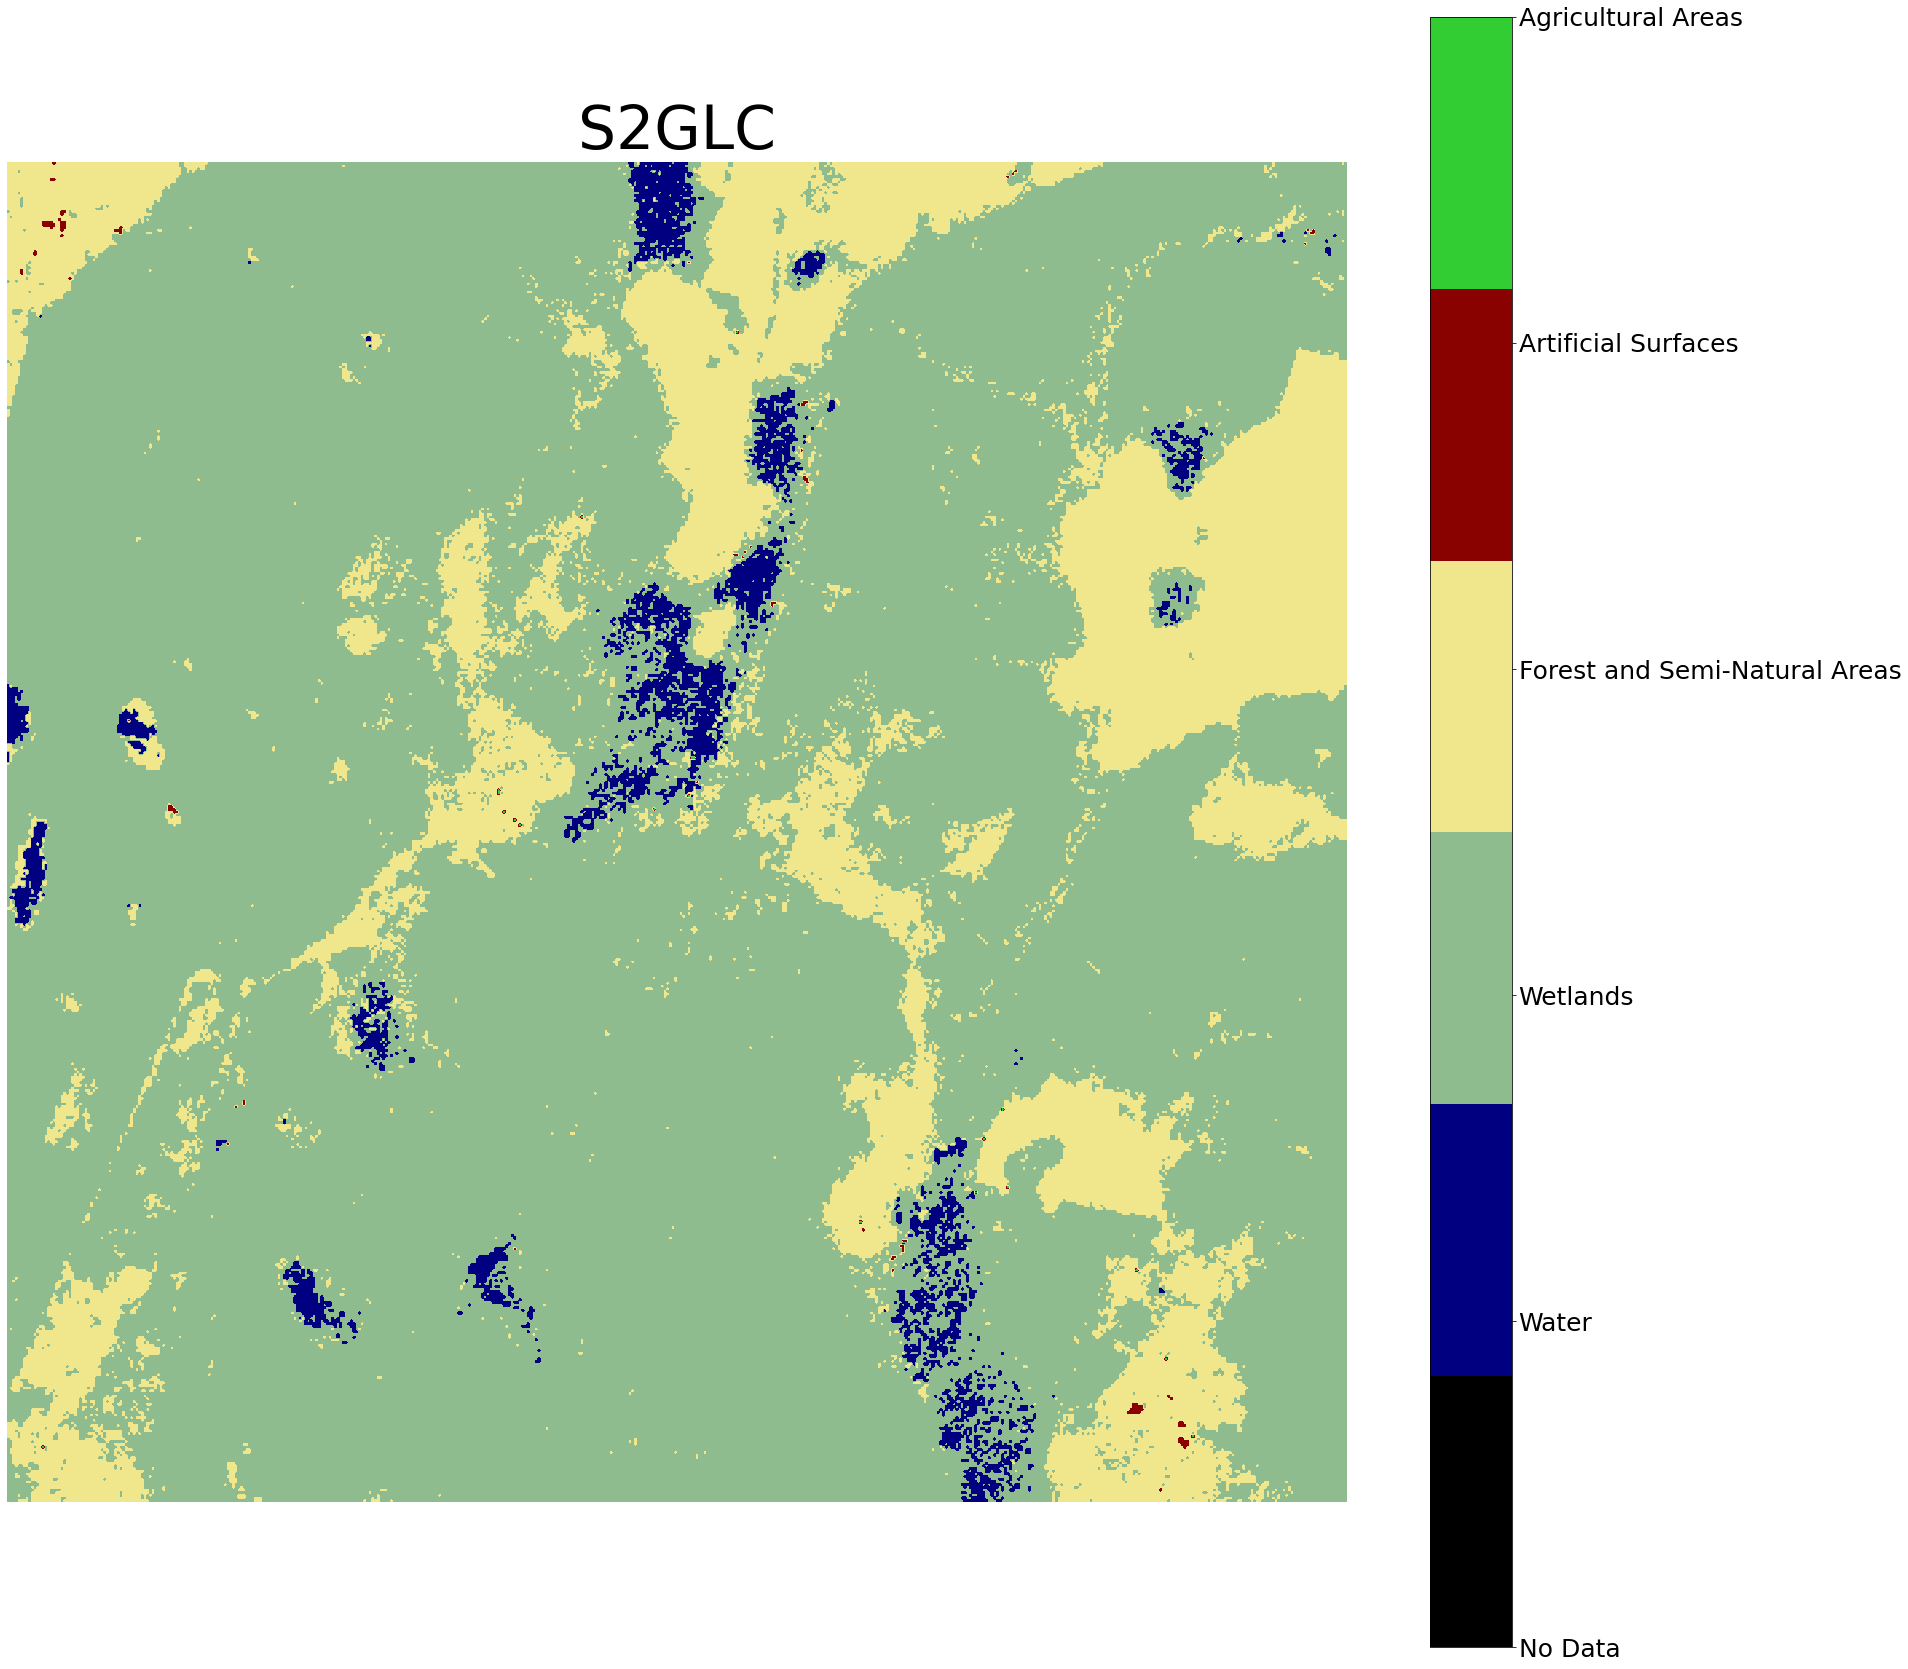

In [60]:
fig=plt.figure(figsize=(30,30))
ax=fig.gca()
c=ax.imshow(PriS2G,vmin=0,vmax=5,cmap=col)

ax.axis('off')

cb=plt.colorbar(c, ax=ax, ticks=np.arange(0,len(Labels)))#extendfrac='auto', spacing='proportional')   
cb.set_ticklabels(Labels)
cb.ax.tick_params(labelsize=25)
plt.title('S2GLC',fontsize= 60)
fig.savefig('LimerickS2GNew.png',format='png',quality=95,bbox_inches='tight')

#Sentinel & UW

##Sentinel transforming

In [61]:


warpSEN = 'rgb3035.tif'
inSEN = 'rgb.tif'
dsSEN = gdal.Open(inSEN)


gdal.Warp(warpSEN, dsSEN, dstSRS=projectionTO,srcSRS=projection)

outSEN='rgbcut3035.tif'
ds1SEN=gdal.Open(warpSEN)
gdal.Translate(outSEN,ds1SEN,projWin = [xmin,ymax,xmax,ymin],projWinSRS=projectionTO)
projection

'EPSG:32629'

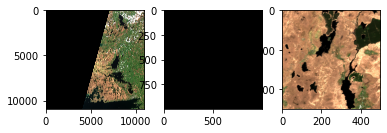

In [62]:

fig, axs = plt.subplots(1, 3)
ax0=axs[0]
ax0.imshow(gdal.Open('rgb.tif').ReadAsArray().transpose(1,2,0))
ax1=axs[1]
ax1.imshow(gdal.Open('rgb3035.tif').ReadAsArray().transpose(1,2,0)[3000:4000,3000:4000,:])
ax2=axs[2]
ax2.imshow(gdal.Open('rgbcut3035.tif').ReadAsArray().transpose(1,2,0))

In [63]:
#!gdalinfo S2GLC.tif

In [64]:
#!gdalinfo Pred3035cut.tif

In [65]:
#!gdalinfo $outSEN

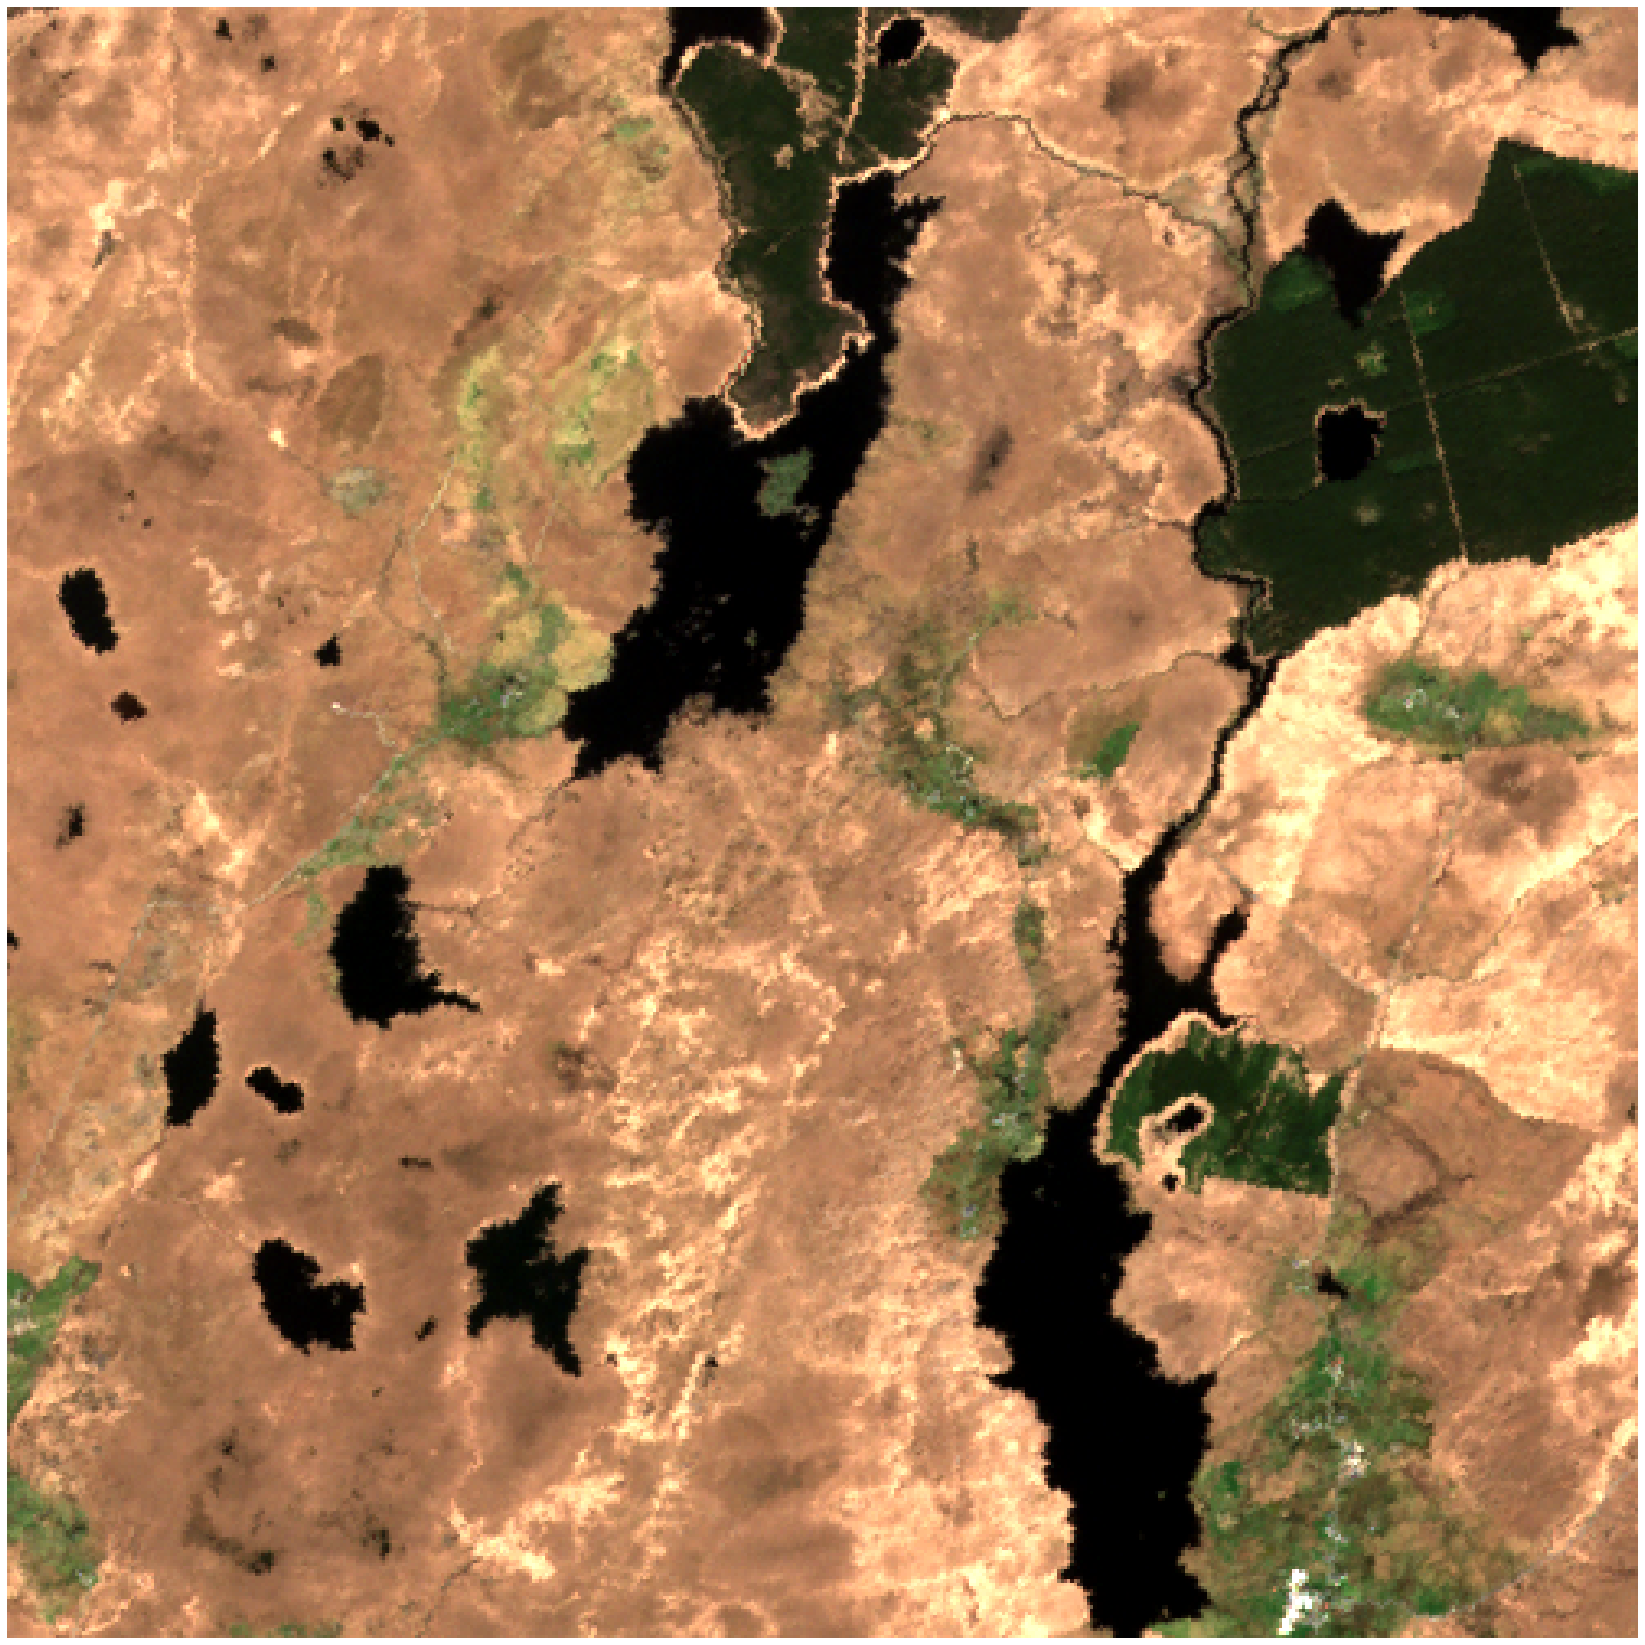

In [66]:
fig=plt.figure(figsize=(30,30))
ax=fig.gca()

c = ax.imshow(gdal.Open(outSEN).ReadAsArray().transpose(1,2,0), vmin=0,vmax=5,cmap=col)
#cb=plt.colorbar(c, ax=ax, ticks=np.arange(0,len(Labels)))#extendfrac='auto', spacing='proportional')   
#cb.set_ticklabels(Labels)
#cb.ax.tick_params(labelsize=15)
ax.axis('off')

fig.savefig('PresentationSENNew.png',format='png',quality=95,bbox_inches='tight')


##UW transform

In [68]:

warpUW = 'Pred3035.tif'
inUW = 'Prediction10m.tif'
dsUW = gdal.Open(inUW)

gdal.Warp(warpUW, dsUW, dstSRS=projectionTO,srcSRS=projection)

outUW='Pred3035cut.tif'
ds1UW=gdal.Open(warpUW)
gdal.Translate(outUW,ds1UW,projWin = [xmin,ymax,xmax,ymin],projWinSRS=projectionTO)

xmin,ymax,xmax,ymin

(3046660.4931802163,
 3528257.5835612444,
 3051660.4931802163,
 3523257.5835612444)

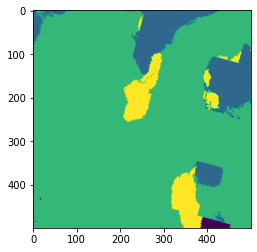

In [69]:
plt.imshow(gdal.Open('Pred3035cut.tif').ReadAsArray())

In [70]:
UW=gdal.Open('Pred3035cut.tif').ReadAsArray()

In [71]:

def UWtoPrimary(array):
  array1 = np.zeros(np.shape(array))
  for i in range(0, len(array)):
    for j in range(0,len(array[0])):
      if array[i,j] == 1:
        array1[i,j] =  4 # artificial
      if array[i,j] == 2:
        array1[i,j] =  5 #agri
      if array[i,j] == 3:
        array1[i,j] =  3 #nature
      if array[i,j] == 4:
        array1[i,j] = 2 #wetlands 
      if array[i,j] == 5:
        array1[i,j] = 1  #water
      
  return array1

In [72]:
UWPri = UWtoPrimary(UW)
UWPri

array([[3., 3., 3., ..., 2., 2., 2.],
       [3., 3., 3., ..., 2., 2., 2.],
       [3., 3., 3., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

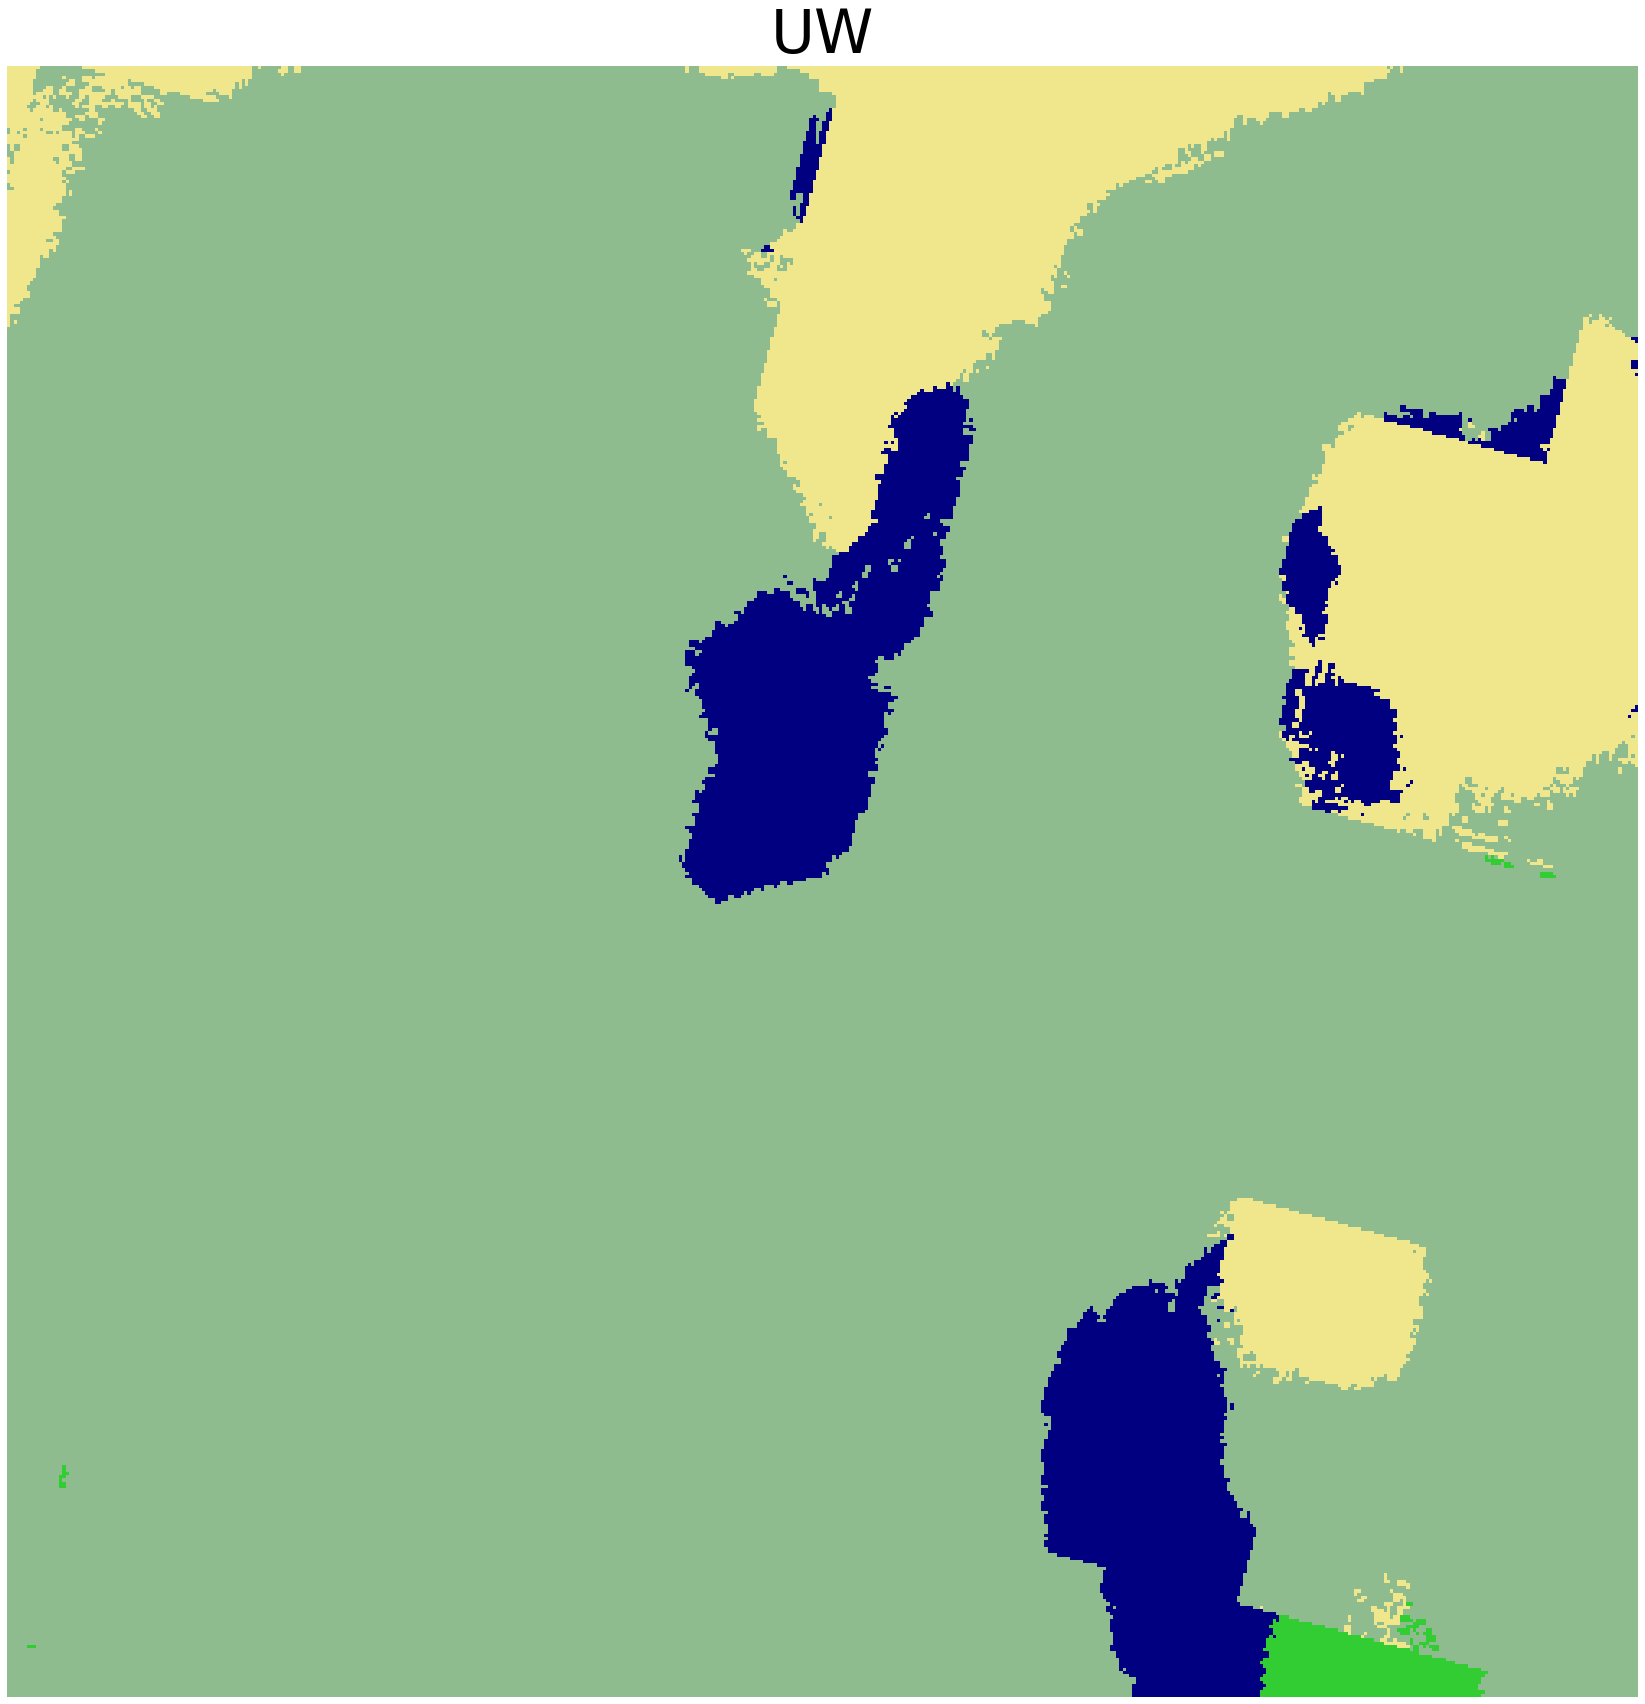

In [73]:
fig=plt.figure(figsize=(30,30))
ax=fig.gca()

c = ax.imshow(UWPri,vmin = 0, vmax = 6 , cmap=col)
#cb=plt.colorbar(c, ax=ax, ticks=np.arange(0,len(Labels)))#extendfrac='auto', spacing='proportional')   
#cb.set_ticklabels(Labels)
#cb.ax.tick_params(labelsize=15)
ax.axis('off')
plt.title('UW',fontsize= 60)
fig.savefig('GalwayBogUWNew.png',format='png',quality=95,bbox_inches='tight')

# Stats

##Bar Charts

In [74]:
def Bar(array):
  
  water =  0
  wetlands = 0
  nature = 0
  urban = 0 
  agri = 0
  for i in range(0, len(array)):
    for j in range(0,len(array[0])):

      if array[i,j] == 1:
        water +=1
      if array[i,j] ==2:
        wetlands +=1  
      if array[i,j] ==3:
        nature +=1
      if array[i,j] ==4:
        urban +=1
      if array[i,j] ==5:
        agri +=1
  a = np.array([water,wetlands,nature,urban,agri])/np.size(array)*100
  return a


In [75]:
BarUW = Bar(UWPri)
BarS2G = Bar(PriS2G)
BarCOR = Bar(PriCOR)
BarECO = Bar(PriECO)
BarESA = Bar(PriESA)


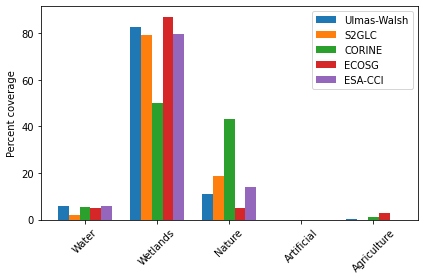

[ 5.956  82.7332 10.816   0.      0.4948] [2.12680e+00 7.91304e+01 1.86864e+01 4.84000e-02 8.00000e-03] [ 5.49788543 50.09611688 43.1372549   0.          1.26874279] [ 4.84429066 87.15878508  4.99807766  0.          2.9988466 ] [5.99769319e+00 7.98539023e+01 1.41099577e+01 0.00000000e+00
 3.84467512e-02]


In [92]:


labels = ['Water','Wetlands','Nature', 'Artificial','Agriculture']
fig, ax = plt.subplots()
ax.set_ylabel('Percent coverage')
#ax.set_title('Distribution of primary covertypes for _____')



data = [BarUW,BarS2G,BarCOR,BarECO,BarESA]
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

rects1 = ax.bar(x - width, data[0], width/2, label='UW')
rects2 = ax.bar(x - width/2, data[1], width/2, label='S2G')
rects3 = ax.bar(x           , data[2], width/2, label='COR')
rects4 = ax.bar(x + width/2, data[3], width/2, label='ECO')
rects5 = ax.bar(x + width, data[4], width/2, label='ESA')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent coverage')
#ax.set_title('Distribution of primary covertypes for CORINE, ECOCLIMAP and ESA-CCI')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10, rotation=45)
ax.legend(labels=['Ulmas-Walsh','S2GLC','CORINE','ECOSG','ESA-CCI'])

fig.tight_layout()

plt.show()
fig.savefig('BarLimerickNew.png',format='png',quality=95,bbox_inches='tight')
print(BarUW,BarS2G,BarCOR,BarECO,BarESA)

In [77]:
#comboplot
def diffBar(array1,array2,labels):
  if np.shape(array1) != np.shape(array2):
    return print('Error, dimensions of arrays are inconsistent')
  b = len(labels)
  a = np.zeros([b,b])
  for i in range(0, len(array1)):
    for j in range(0,len(array1[0])):
      for k in range(0,b):
        for f in range(0,b):
          if array1[i,j] == k+1:
            if array2[i,j]==f+1:
              a[k,f] += 1
  return a/np.size(array1)*100

In [84]:
CoverType = Labels[1:]


In [90]:
Dif_UW_S2G=diffBar(UWPri,PriS2G, CoverType)
Dif_UW_S2G

array([[1.25600e+00, 3.40400e+00, 1.28760e+00, 6.40000e-03, 2.00000e-03],
       [7.03200e-01, 7.30276e+01, 8.96720e+00, 2.96000e-02, 5.60000e-03],
       [1.67600e-01, 2.63760e+00, 7.99840e+00, 1.20000e-02, 4.00000e-04],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 6.12000e-02, 4.33200e-01, 4.00000e-04, 0.00000e+00]])

In [89]:
print(x)
print(data[1,:])
print(labels[0])
print(bar12)

[0 1 2 3 4]
[7.03200e-01 7.30276e+01 8.96720e+00 2.96000e-02 5.60000e-03 0.00000e+00]
Water
[1.9592, 76.4316, 10.2548, 0.036, 0.0076, 0.0]


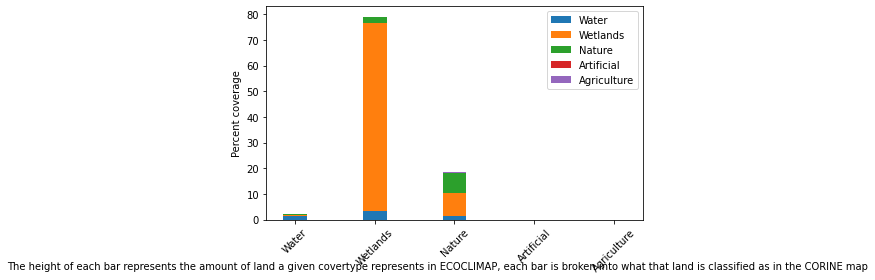

In [95]:

fig, ax = plt.subplots()

data =Dif_UW_S2G
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

bar12 = np.add(data[0,:], data[1,:]).tolist()
bar123 = np.add(bar12, data[2,:]).tolist()
bar1234 = np.add(bar123, data[3,:]).tolist()
bar12345 = np.add(bar1234, data[4,:]).tolist()



ax.bar(x , data[0,:], width, label=labels[0])
ax.bar(x , data[1,:], width, bottom=data[0,:], label=labels[1])
ax.bar(x , data[2,:], width, bottom=bar12, label=labels[2])
ax.bar(x , data[3,:], width, bottom=bar123,label=labels[3])
ax.bar(x , data[4,:], width, bottom=bar1234,label=labels[4])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent coverage')
#ax.set_title("What land in ECOCLIMAP correponds to in CORINE map.")
txt = "The height of each bar represents the amount of land a given covertype represents in S2GLC, each bar is broken into what that land is classified as in the UW map"
fig.text(.5, .05, txt, ha='center')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10, rotation=45)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()
fig.savefig('Bar2.png',format='png',quality=95,bbox_inches='tight')

##Countrywide breakdown

In [ ]:
def count(array):
    
  water =  0
  wetlands = 0
  nature = 0
  urban = 0 
  agri = 0
  
  for i in range(0, len(array)):
    for j in range(0,len(array[0])):

      if array[i,j] == 1:
        water +=1
      if array[i,j] ==2:
        wetlands +=1  
      if array[i,j] ==3:
        nature +=1
      if array[i,j] ==4:
        urban +=1
      if array[i,j] ==5:
        agri +=1
  
  return water,wetlands,nature,urban,agri

In [ ]:
def CORINE(xmin,ymax,xmax,ymin): 
  LATC,LONC, DCOR = get_data('CORINEcut100m.tif',ymax,ymin,xmax,xmin)
  PriCOR = toPrimaryDF(DCOR,df_COR,4,5,covername_COR)
  return PriCOR

def ECO(xmin,ymax,xmax,ymin):
  LATECO,LONECO, DECO = get_data(outECO,ymax,ymin,xmax,xmin)
  PriECO = toPrimaryDF(DECO,df_ECO,4,5,covername_ECO)
  return PriECO

def S2G(xmin,ymax,xmax,ymin):
  ds=gdal.Open('/content/drive/MyDrive/S2GLCmap/S2GLC_Europe_2017_v1.2.tif')
  Topt=gdal.TranslateOptions(projWin= [xmin, ymax, xmax, ymin],projWinSRS='EPSG:3035')
  gdal.Translate('S2GLC.tif',ds,options=Topt)
  ds=None

  dsS2G=gdal.Open('S2GLC.tif')
  Ar=dsS2G.ReadAsArray()
  Arp=np.zeros(Ar.shape)
  for i,u in enumerate(U):
      Arp[Ar==u]=i

  PriS2G = toPrimaryDF(Arp,df_S2G,4,5,labellist)

def ESA(xmin,ymax,xmax,ymin):
  LATESA,LONESA, DESA = get_data(outESA,ymax,ymin,xmax,xmin)
  PriESA = toPrimaryDF(DESA,df_ESA,1,4,covername_ESA)
  return PriESA



In [ ]:
def stats(map,ulx, uly,lrx,lry,fname):
  xlen = np.abs(ulx - lrx)
  ylen = np.abs(uly - lry)
  
  extent = 5000
  a = xlen/extent
  b = ylen/extent

  #x1, x2 = ulx, ulx + extent
  #y1, y2 = uly, uly + extent

  water,wetlands,nature,urban,agri = 0,0,0,0,0

  for i in range(0,a): #repetition in x direction
    for j in range(0,b): #repetition in x direction
      x1, x2 = ulx + extent*i, ulx + extent*(i+1)
      y1, y2 = uly + extent*j, uly + extent*(j+1)

      array = CORINE(fname,x1,y2,x2,y1)
      







      water1,wetlands1,nature1,urban1,agri1 = count(array)
      water += water1
      wetlands += wetlands1
      nature += nature1
      urban += urban1
      agri += agri1

  return water,wetlands,nature,urban,agri

In [ ]:
def stats():
  for a in range(0,100): #eg 100
    for b in range(0,120):
      xmin1 = xmin + a*100
      xmax1 = xmin + a*100 + 100
      #etc
      for i in range(): #rows primary array
        for j in range(): #columns primary array
          if array[i,j]=1:
            water +=1
          if array[i,j]=2:
            wetlands +=1
          if array[i,j]=3:
            nature +=1
          if array[i,j]=4:
            art +=1
          if array[i,j]=5:
            agri +=1

In [ ]:
fig, axs = plt.subplots(1, 3)
ax0=axs[0]
ax0.imshow(gdal.Open('Prediction10m.tif').ReadAsArray())
ax1=axs[1]
ax1.imshow(ds1UW.ReadAsArray())
ax2=axs[2]
ax2.imshow(UW)